<h1><center><font size="25">Time series forecasting with Python and Scikit-learn</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>February, 2021 (last update December 2021)</i></center>

## Introduction
<br>

A [time series](https://en.wikipedia.org/wiki/Time_series) is a succession of chronologically ordered data spaced at equal or unequal intervals. The [forecasting](https://en.wikipedia.org/wiki/Forecasting#Time_series_methods) process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables.

This paper describes how to use **Scikit-learn** regression models to perform forecasting on time series. Specifically, it introduces [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/), a simple package that contains the classes and functions necessary to adapt any **Scikit-learn** regression model to forecasting problems.
<br><br>

## Multi-Step Time Series Forecasting
<br>

The common objective of working with time series is not only to predict the next element in the series ($t_{+1}$) but an entire future interval or a point far away in time ($t_{+n}$). Each prediction jump is known as a step.

In [78]:
repeat_it = 0

if repeat_it == 1:
    import gif
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd

    np.random.seed(1234)
    y = 10 * np.sin(np.arange(0, 10, 0.1))
    y = y + np.random.normal(loc=0.0, scale=4, size = len(y))
    datetime = pd.date_range(start='1/1/2020', periods=len(y), freq='D')
    datos = pd.Series(y, index=datetime)

    # fig, ax = plt.subplots(figsize=(9, 4))
    # datos[:-30].plot(ax=ax, c='c', marker='o', label='pasado',  zorder=3)
    # datos[-31:].plot(ax=ax, c='gray', label='futuro')
    # datos[-30:-15].plot(ax=ax, c='red', marker='o', linestyle='',
    #                        label='Valores predichos')
    # datos[[-15]].plot(ax=ax, c='red', marker='X', linestyle='', markersize=12,
    #                        label='Valor a predecir')
    # ax.set_title('Predecir un intervalo a futuro')
    # ax.legend();

    frames = []

    @gif.frame
    def custom_plot(i, j):
        fig, ax = plt.subplots(figsize=(9, 4))
        datos[:-30].plot(ax=ax, c='c', marker='o', label='past',  zorder=3)
        datos[-31:].plot(ax=ax, c='gray', label='future')

        datos.iloc[len(datos)-30:i+1].plot(ax=ax, c='red', marker='o', linestyle='',
                                           label='predicted value')

        datos.iloc[[i]].plot(ax=ax, c='red', marker='X', linestyle='',
                             markersize=12,label='value to be predicted')
        ax.set_title(f'Recursive multi-step forecasting: (t+{j})')
        ax.legend()

        return(ax)

    j=1
    for i in range(len(datos)-30, len(datos)):
        frame = custom_plot(i, j)
        frames.append(frame)
        j+=1

    gif.save(frames, './images/forecasting_multi-step_EN.gif', duration=10, unit="s", between="startend")

There are several strategies that allow generating this type of multiple prediction.
<br><br>

**Recursive multi-step forecasting**
<br>

Since to predict the moment $t_{n}$ the value of $t_{n-1}$ is needed, which is unknown, it is necessary to make recursive predictions. New predictions use previous ones as predictors. This process is known as recursive forecasting or recursive multi-step forecasting.

<div>
<img src='./images/forecasting_multi-step_EN.gif' width="600"/>
</div>

The main adaptation needed to apply [Scikit-learn](https://scikit-learn.org/stable/) models to recursive multi-step forecasting problems is to transform the time series into a matrix in which each value is associated with the time window (lags) preceding it. This forecasting strategy can be easily generated with the `ForecasterAutoreg` and `ForecasterAutoregCustom` classes from the **Skforecast** package.

<img src="./images/transform_timeseries.gif" style="width: 550px;">

In [14]:
from IPython.core.display import HTML
HTML("<center><font size='2.5'> <i>" +
"Transformation of a time series into a 5 lags matrix and a vector with the value of the series that follows each row of the matrix." +
     "</i></font></center>")

This type of transformation also allows the inclusion of exogenous variables to the time series.

<img src="./images/matrix_transformation_with_exog_variable.png" style="width: 550px;">

<center><font size='2.5'> <i>Transformation of a time series joining an exogenous variable.</i></font></center>

**Direct multi-step forecasting**
<br>


The direct multi-step forecasting method consists of training a different model for each step. For example, to predict the following 5 values of a time series, 5 different models are required to be trained, one for each step. As a result, the predictions are independent of each other.

The main complexity of this approach is to generate the correct training matrices for each model. The `ForecasterAutoregMultiOutput` class of the [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/) package automates this process. It is also important to bear in mind that this strategy has a higher computational cost since it requires the train of multiple models. The following diagram shows the process for a case in which the response variable and two exogenous variables are available.

<img src="./images/diagram_skforecast_multioutput.png" style="width: 900px;">

<center><font size='2.5'> <i>Transformation of a time series into the necessary matrices to train a direct multi-step forecasting model.</i></font></center>
    
<br><br>

**Multiple output forecasting**
<br>

Certain models are capable of simultaneously predicting several values of a sequence (one-shot). An example of a model with this capability is the LSTM neural network.
<br><br>

## Recursive autoregressive forecasting
<br>

A time series is available with the monthly expenditure (millions of dollars) on corticosteroid drugs that the Australian health system had between 1991 and 2008. It is intended to create an autoregressive model capable of predicting future monthly expenditures.
<br><br>

### Packages
<br>

The packages used in this paper are:

In [ ]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In addition to the above, [**Skforecast**](https://github.com/JoaquinAmatRodrigo/skforecast), a library containing the classes and functions needed to adapt any **Scikit-learn** regression model to forecasting problems, is used. It can be installed in the following ways:

`pip install skforecast`

A specific version:

`pip install git+https://github.com/JoaquinAmatRodrigo/skforecast@v0.3.0`

Last version (unstable):

`pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master`

In [16]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

### Data
<br>

The data used in the examples of this paper have been obtained from the magnificent book [Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

In [17]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv'
data_raw = pd.read_csv(url, sep=',')
data_raw = data_raw.rename(columns={'fecha': 'date'})

The column *date* has been stored as a `string`. To convert it to `datetime` the `pd.to_datetime()` function can be use. Once in `datetime` format, and to make use of **pandas** functionalities, it is set as an index. Also, since the data is monthly, the frequency is set as Monthly Started 'MS'.

In [18]:
# Data preparation
# ==============================================================================
data = data_raw.copy()
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

The time series is verified to be complete.

In [19]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [20]:
# Fill gaps in a temporary index
# ==============================================================================
# data.asfreq(freq='30min', fill_value=np.nan)

The last 36 months are used as the test set to evaluate the predictive capacity of the model.

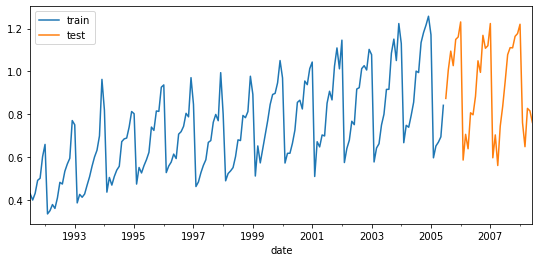

In [21]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg
<br>

With the `ForecasterAutoreg` class, a model is created and trained from a `RandomForestRegressor` regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [22]:
# Create and train forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=123),
                    lags=6
                )

forecaster_rf.fit(y=data_train)

forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=123)
Lags: [1 2 3 4 5 6]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

### Predictions
<br>

Once the model is trained, the test data is predicted (36 months into the future).

In [23]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster_rf.predict(steps=steps)
# Temporal index is added to predictions
predictions = pd.Series(data=predictions, index=data_test.index)
predictions.head()

date
2005-07-01    0.866263
2005-08-01    0.874688
2005-09-01    0.951697
2005-10-01    0.991223
2005-11-01    0.952589
Freq: MS, dtype: float64

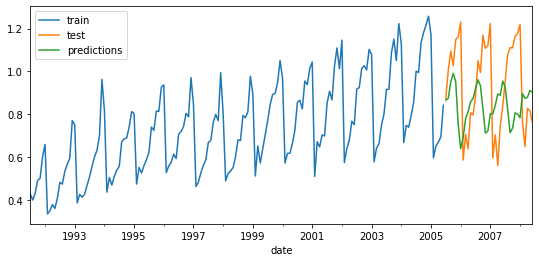

In [24]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set
<br>

The error that the model makes in its predictions is quantified. In this case, the metric used is the mean squared error (mse).

In [25]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.0665147739321922


### Hyperparameter tuning
<br>

The trained `ForecasterAutoreg` uses a 6 lag time window and a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model with the default hyperparameters. However, there is no reason why these values are the most suitable.

To identify the best combination of lags and hyperparameters, [time series cross-validation and backtesting](https://joaquinamatrodrigo.github.io/skforecast/0.3/guides/cross-validation-backtest.html) strategies are available in the **Skforecast** package. Regardless of the procedure used, it is important not to include the test data in the search process to avoid overfitting problems. [Time series cross-validation](https://joaquinamatrodrigo.github.io/skforecast/0.3/guides/cross-validation-backtest.html) along the training dataset is used in this case. For the first fold, the initial 50% of the observations are the training data and, the next 10 steps represent the validation set. In successive folds, the training set will contain all the data used in the previous fold and, the next 10 steps will be used as new validation data. This process will be repeated until the entire training data set is used.


In [26]:
# Hyperparameter Grid search
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 12 # This value will be replaced in the grid search
                 )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags used as predictors
lags_grid = [10, 20]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = data_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

2021-12-01 12:59:45,261 root       INFO  Number of models compared: 12
loop lags_grid: 100%|████████████████████████████████████████████████████████████████████| 2/2 [01:02<00:00, 31.35s/it]
2021-12-01 13:00:47,990 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
params: {'max_depth': 10, 'n_estimators': 500}



In [27]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,metric,max_depth,n_estimators
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.005271,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.005331,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.005354,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.005514,5,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.005744,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.005821,3,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.026603,10,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.028092,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.028693,5,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.028870,5,500


The best results are obtained using a time window of 20 lags and a Random Forest set up of {'max_depth': 10, 'n_estimators': 500}.

### Final model
<br> 

Finally, a `ForecasterAutoreg` is trained with the optimal configuration found by validation. This step is not necessary if `return_best = True` is specified in the `grid_search_forecaster()` function.

In [28]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 20
                )

forecaster_rf.fit(y=data_train)

In [29]:
# Predictions
# ==============================================================================
predictions = forecaster_rf.predict(steps=steps)
# Temporal index is added to predictions
predictions = pd.Series(data=predictions, index=data_test.index)

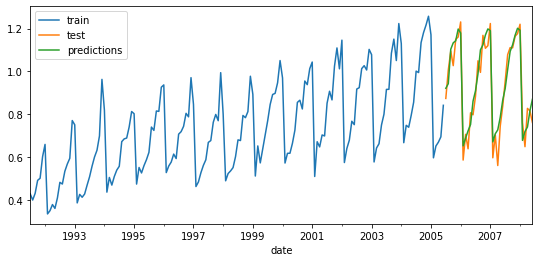

In [30]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [31]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.003977043111878048


The optimal combination of hyperparameters significantly reduces test error.
<br><br>

### Predictors importance
<br>

Since the `ForecasterAutoreg` object uses **Scikit-learn** models, the importance of predictors can be accessed once trained. When the regressor used is a `LinearRegression()`, `Lasso()` or `Ridge()`, the coefficients of the model reflect their importance, obtained with the `get_coef()` method. In `GradientBoostingRegressor()` or `RandomForestRegressor()` regressors, the importance of predictors is based on impurity reduction and is accessible through the `get_feature_importances()` method. In both cases, the values returned are sorted as the lags order.

In [32]:
# Predictors importance
# ==============================================================================
importance = forecaster_rf.get_feature_importances()
dict(zip(forecaster_rf.lags, importance))

{1: 0.012553886713487067,
 2: 0.08983951332807712,
 3: 0.010659102591406499,
 4: 0.002089457758242796,
 5: 0.0020659673443678183,
 6: 0.0025603607878369916,
 7: 0.002581234419075129,
 8: 0.006926666631373768,
 9: 0.011527319810863244,
 10: 0.025368130077705796,
 11: 0.0179467896103424,
 12: 0.7756201041018169,
 13: 0.003187087706488905,
 14: 0.014718107972907112,
 15: 0.00787688226587692,
 16: 0.0034805919651981015,
 17: 0.002711614234150025,
 18: 0.002041714855087625,
 19: 0.001887665438745876,
 20: 0.004357802386950056}

### Comparison with Statsmodels
<br>

The [**Statsmodels**](https://www.statsmodels.org/stable/examples/index.html#time-series-analysis) package has some of the main forecasting models (*AutoReg*, *AR*, *ARMA*, *ARIMA*). It is verified that the same results are obtained with *AutoReg* as with the class `ForecasterAutoreg` with `LinearRegression()` as regressor.

In [33]:
# Linear autoregressive model (Statsmodels)
# ==============================================================================
from statsmodels.tsa.ar_model import AutoReg
lags = 15

model_ar = AutoReg(data_train, lags=lags)
res = model_ar.fit()
predictions_statsmodels = res.predict(start=data_test.index[0], end=data_test.index[-1])

# Linear autoregressive model (Skforecast)
# ==============================================================================
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)
forecaster.fit(y=data_train)
predictions_forecaster = forecaster.predict(steps=36)

# Verification that the predictions of both models are the same
# ==============================================================================
print(np.allclose(predictions_statsmodels.values, predictions_forecaster))

# Verification that the coefficients of both models are equal
# ==============================================================================
print(np.allclose(res.params.values[1:], forecaster.get_coef()))

True
True


## Recursive autoregressive forecasting with exogenous variables
<br>

In the previous example, only lags of the predicted variable itself have been used as predictors. In certain scenarios,  it is possible to have information about other variables, **whose future value is known**, so could serve as additional predictors in the model.

Continuing with the previous example, a new variable whose behavior is correlated with the modeled time series and it is wanted to incorporate as a predictor is simulated. The same applies to multiple exogenous variables.
<br><br>

### Data

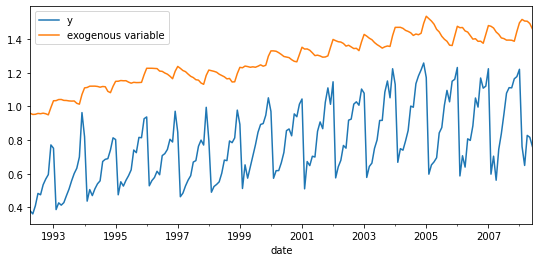

In [34]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data_raw = pd.read_csv(url, sep=',')
data_raw = data_raw.rename(columns={'fecha': 'date'})

# Data preparation
# ==============================================================================
data = data_raw.copy()
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

fig, ax = plt.subplots(figsize=(9, 4))
data['y'].plot(ax=ax, label='y')
data['exog_1'].plot(ax=ax, label='exogenous variable')
ax.legend();

In [35]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

### ForecasterAutoreg

In [36]:
# Create and train forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 8
                )

forecaster_rf.fit(y=data_train['y'], exog=data_train['exog_1'])

### Predictions
<br>

If the `ForecasterAutoreg` is trained with an exogenous variable, the value of this variable must be passed to `predict()`. It is only applicable to scenarios in which future information on the exogenous variable is available.

In [37]:
# Predictions
# ==============================================================================
predictions = forecaster_rf.predict(steps=steps, exog=data_test['exog_1'])
# Temporal index is added to predictions
predictions = pd.Series(data=predictions, index=data_test.index)

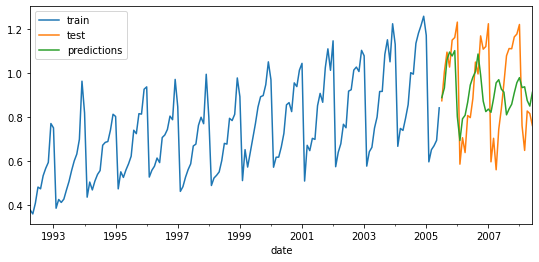

In [38]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set

In [39]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.03989087922533575


### Hyperparameter tuning

In [40]:
# Hyperparameter Grid search
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 12 # This value will be replaced in the grid search
                 )

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = data_train['y'],
                        exog        = data_train['exog_1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

2021-12-01 13:00:54,366 root       INFO  Number of models compared: 27
loop lags_grid: 100%|████████████████████████████████████████████████████████████████████| 3/3 [01:50<00:00, 36.85s/it]
2021-12-01 13:02:44,948 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
params: {'max_depth': 3, 'n_estimators': 50}



In [41]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,metric,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 50}",0.007815,3,50
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 50}",0.007940,5,50
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.007944,3,500
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.008057,3,100
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.008106,10,100


The best results are obtained using a time window of 12 lags and a Random Forest set up of {'max_depth': 3, 'n_estimators': 50}.

### Final model
<br>

Setting `return_best = True` in the `grid_search_forecaster()`, after the search, the `ForecasterAutoreg` object has been modified and trained with the best match found.

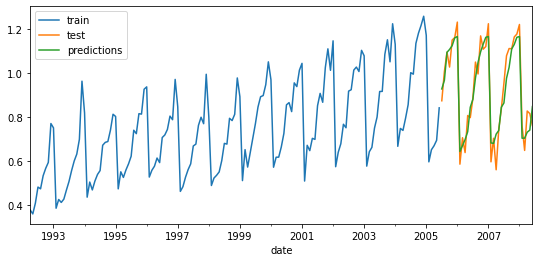

In [42]:
# Predictions
# ==============================================================================
predictions = forecaster_rf.predict(steps=steps, exog=data_test['exog_1'])
# Temporal index is added to predictions
predictions = pd.Series(data=predictions, index=data_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [43]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.003965444559763559


## Recursive autoregressive forecasting with custom predictors
<br>

In addition to the lags, it may be interesting to incorporate other characteristics of the time series in some scenarios. For example, the moving average of the last *n* values could be used to capture the series's trend.

The `ForecasterAutoregCustom` class behaves very similar to the `ForecasterAutoreg` class seen in the previous sections, but with the difference that it is the user who defines the function used to create the predictors.

The first example of the paper about predicting the last 36 months of the time series is repeated. In this case, the predictors are the first 10 lags and the values' moving average of the lasts 20 months.
<br><br>

### Data

In [44]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv'
data_raw = pd.read_csv(url, sep=',')
data_raw = data_raw.rename(columns={'fecha': 'date'})

In [45]:
# Data preparation
# ==============================================================================
data = data_raw.copy()
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

In [46]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

### ForecasterAutoregCustom
<br>

A `ForecasterAutoregCustom` is created and trained from a `RandomForestRegressor` regressor. The `create_predictor()` function,  which calculates the first 10 lags and the moving average of the last 20 values, is used to create the predictors.

In [47]:
# Function to calculate predictors from time series
# ==============================================================================
def create_predictors(y):
    '''
    Create the first 10 lags.
    Calculate the moving average of the last 20 values.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train  

When creating the forecaster, the `window_size` argument must be equal to or greater than the window used by the function that creates the predictors. This value, in this case, is 20.

In [48]:
# Create and train forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster_rf.fit(y=data_train)
forecaster_rf

=======================ForecasterAutoregCustom=======================
Regressor: RandomForestRegressor(random_state=123)
Predictors created with: create_predictors
Window size: 20
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

### Predictions

In [49]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster_rf.predict(steps=steps)
# Temporal index is added to predictions
predictions = pd.Series(data=predictions, index=data_test.index)

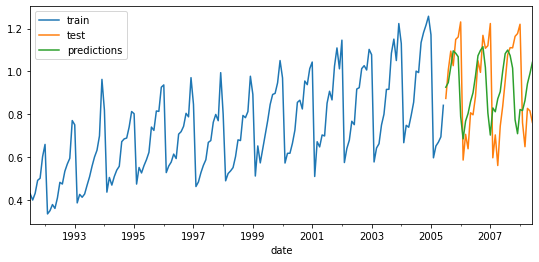

In [50]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set

In [51]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.04487765885818191


### Hyperparameter tuning
<br>

When using the `grid_search_forecaster()` function with a `ForecasterAutoregCustom`, the` lags_grid` argument is not specified.

In [52]:
# Hyperparameter Grid search
# ==============================================================================
forecaster_rf = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = data_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = True,
                        return_best = True,
                        verbose     = False
                    )

2021-12-01 13:02:47,802 root       INFO  Number of models compared: 6
loop lags_grid: 100%|████████████████████████████████████████████████████████████████████| 1/1 [01:14<00:00, 74.56s/it]
2021-12-01 13:04:02,378 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 500}



In [53]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,metric,max_depth,n_estimators
5,custom predictors,"{'max_depth': 10, 'n_estimators': 500}",0.022736,10,500
3,custom predictors,"{'max_depth': 5, 'n_estimators': 500}",0.022742,5,500
4,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.023564,10,100
2,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.024030,5,100
1,custom predictors,"{'max_depth': 3, 'n_estimators': 500}",0.025694,3,500
0,custom predictors,"{'max_depth': 3, 'n_estimators': 100}",0.026545,3,100


### Final model

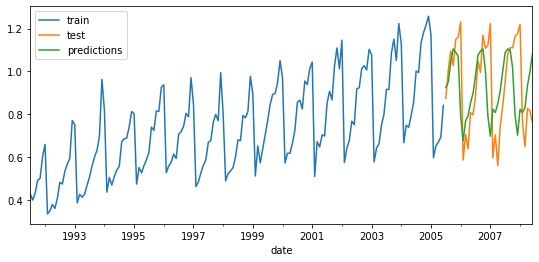

In [54]:
# Predictions
# ==============================================================================
predictions = forecaster_rf.predict(steps=steps)
# Temporal index is added to predictions
predictions = pd.Series(data=predictions, index=data_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [55]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test, y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.044590618568342955


## Direct multi-step forecasting
<br>

The `ForecasterAutoreg` and `ForecasterAutoregCustom` models follow a recursive prediction strategy in which each new prediction builds on the previous one. An alternative is to train a model for each of the steps to be predicted. This strategy, commonly known as direct multi-step forecasting, is computationally more expensive than recursive since it requires training several models. However, in some scenarios, it achieves better results. These kinds of models can be obtained with the `ForecasterAutoregMultiOutput` class and can include one or multiple exogenous variables.
<br><br>


### Data

In [56]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv'
data_raw = pd.read_csv(url, sep=',')
data_raw = data_raw.rename(columns={'fecha': 'date'})

# Data preparation
# ==============================================================================
data = data_raw.copy()
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

In [57]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

### ForecasterAutoregMultiOutput
<br>

Unlike when using `ForecasterAutoreg` or `ForecasterAutoregCustom`, the number of steps to be predicted must be indicated in the `ForecasterAutoregMultiOutput` type models. This means that the number of predictions obtained when executing the `predict()` method is always the same.

In [58]:
# Hyperparameter Grid search
# ==============================================================================
forecaster_rf = ForecasterAutoregMultiOutput(
                    regressor = Lasso(random_state=123),
                    steps     = 36,
                    lags      = 8 # This value will be replaced in the grid search
                )

param_grid = {'alpha': np.logspace(-5, 5, 10)}

lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = data_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

2021-12-01 13:04:06,252 root       INFO  Number of models compared: 30
loop lags_grid: 100%|████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.52it/s]
2021-12-01 13:04:08,254 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
params: {'alpha': 0.0016681005372000592}



In [59]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,metric,alpha
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0016681005372000592},0.009650,0.001668
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.0016681005372000592},0.009872,0.001668
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0001291549665014884},0.012075,0.000129
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 1e-05},0.012371,0.000010
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.0001291549665014884},0.015304,0.000129


The best results are obtained using a time window of 12 lags and a Lasso setting {'alpha': 0.001668}.

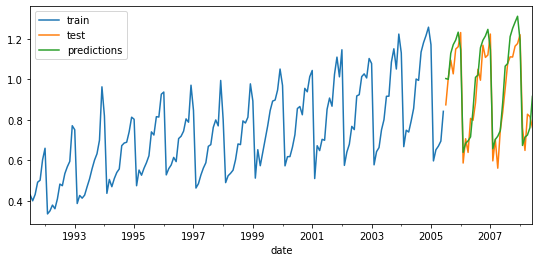

In [60]:
# Predictions
# ==============================================================================
predictions = forecaster_rf.predict()
# Temporal index is added to predictions
predictions = pd.Series(data=predictions, index=data_test.index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [61]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test, y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.008363774087426272


## Backtesting¶
<br>


The [Backtesting](https://joaquinamatrodrigo.github.io/skforecast/0.3/guides/cross-validation-backtest.html) process consists of simulating the behavior that the model would have had if it had been run on a recurring basis, for example, predicting at intervals of 3 years (36 months) a total of 9 years. This type of evaluation can be easily applied with the `backtesting_forecaster()` function. This function returns, in addition to the predictions, an error metric.

In [62]:
# Backtesting
# ==============================================================================
n_test = 36*3 # The last 9 years are separated for the backtest
data_train = data[:-n_test]
data_test  = data[-n_test:]

steps = 36 # 3 year (36 month) folds are used
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data,
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Backtest error: {metric}")

Number of observations used for training: 96
Number of observations used for testing: 108
    Number of folds: 3
    Number of steps per fold: 36
Backtest error: [0.0202643]


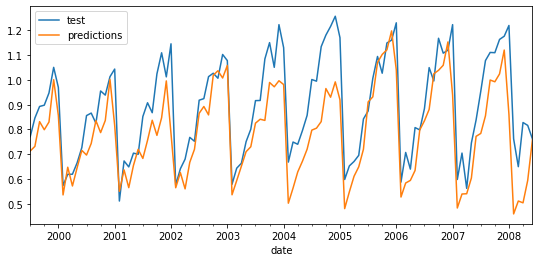

In [63]:
# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=data_test.index)
fig, ax = plt.subplots(figsize=(9, 4))
#data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

## Prediction intervals
<br>

A prediction interval defines the interval within which the true value of $y$ is expected to be found with a given probability.

Rob J Hyndman and George Athanasopoulos, list in their book *Forecasting: Principles and Practice* [multiple ways to estimate prediction intervals](https://otexts.com/fpp2/prediction-intervals.html), most of which require that the residuals (errors) of the model are distributed in a normal way. When this property cannot be assumed, bootstrapping can be resorted to, which only assumes that the residuals are uncorrelated. This is the method used in the **Skforecast** library for the `ForecasterAutoreg` and `ForecasterAutoregCustom` type models.
<br><br>

In [64]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv'
data_raw = pd.read_csv(url, sep=',')
data_raw = data_raw.rename(columns={'fecha': 'date'})

# Data preparation
# ==============================================================================
data = data_raw.copy()
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

Test error (mse): 0.011051937043503724


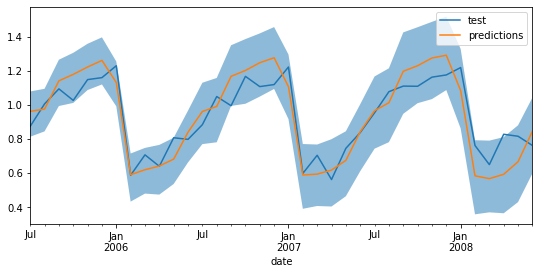

In [65]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor=LinearRegression(),
                    lags=15
                )

forecaster.fit(y=data_train)

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 1000
              )

# Datetime index added
predictions = pd.DataFrame(data=predictions, index=data_test.index)

# Prediction Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

Number of observations used for training: 96
Number of observations used for testing: 108
    Number of folds: 3
    Number of steps per fold: 36
[0.0202643]


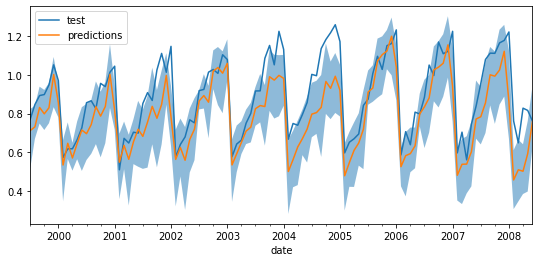

In [66]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3
data_train = data[:-n_test]
data_test  = data[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = data,
                            initial_train_size = len(data_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [1, 99],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True,
                       )

print(metric)

# Datetime index is added
predictions = pd.DataFrame(data=predictions, index=data_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

## Load and save models
<br>

[**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/) models can be loaded and stored using **pickle** or **joblib** packages. A simple example using **joblib** is shown below.

In [69]:
# Packages
# ==============================================================================
from joblib import dump, load

In [70]:
# Create forecaster
forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
forecaster.fit(y=pd.Series(np.arange(50)))

In [79]:
# Save model
dump(forecaster, filename='./models/py27-forecaster.py')

['./models/py27-forecaster.py']

In [80]:
# Load model
forecaster_loaded = load('./models/py27-forecaster.py')

In [76]:
# Predict
forecaster_loaded.predict(steps=5)

array([50., 51., 52., 53., 54.])

## Session info

In [77]:
import session_info
session_info.show(html=False)

-----
ipykernel           6.5.1
joblib              1.1.0
matplotlib          3.5.0
numpy               1.21.4
pandas              1.3.4
session_info        1.0.0
skforecast          0.3.0
sklearn             1.0.1
statsmodels         0.13.1
-----
IPython             7.29.0
jupyter_client      7.1.0
jupyter_core        4.9.1
-----
Python 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19041-SP0
-----
Session information updated at 2021-12-01 13:13


## Bibliography
<br>

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. [Book](https://otexts.com/fpp3/)

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov [Book](https://openforecast.org/adam/)

Python Data Science Handbook by Jake VanderPlas [Book](https://www.amazon.es/gp/product/1491912057/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1491912057&linkId=73620d22f9d4a0a76d27592dabf13c83)

Python for Finance: Mastering Data-Driven Finance [Book](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055)

[Markus Löning, Anthony Bagnall, Sajaysurya Ganesh, Viktor Kazakov, Jason Lines, Franz Király (2019): “sktime: A Unified Interface for Machine Learning with Time Series”](http://learningsys.org/neurips19/assets/papers/sktime_ml_systems_neurips2019.pdf)

[Markus Löning, Tony Bagnall, Sajaysurya Ganesh, George Oastler, Jason Lines, ViktorKaz, …, Aadesh Deshmukh (2020). alan-turing-institute/sktime. Zenodo. http://doi.org/10.5281/zenodo.3749000](https://github.com/alan-turing-institute/sktime)

[**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/)

In [68]:
%%html
<style>
.text_cell_render p {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    #font-size: 16px;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 1.15em
}

#notebook-container {
    background-color: #fcfcfc;
}

div.inner_cell {
    margin-right: 5%;
}

.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
}

.rendered_html code {
    background-color: #f2f2f2;
    font-family: monospace;
    color: #a20505;
    font-size: 15px;
    #font-size: 1em;
    padding: 1px 1px;
    border: solid;
    border-color: darkgray;
    border-width: thin;
}

.rendered_html h1 {
    padding-top: 50px;
}

.rendered_html h2 {
    font-size: 30px
    margin-top: 0;
    font-size: 2.488em;
}

.rendered_html h3 {
    font-size: 25px;
}

.rendered_html h4 {
    font-size: 20px;
}

</style>

**How to cite this paper?**

<p style="text-align:left"><font size="3" color="#555">
Forecasting series temporales con Python y Scikitlearn by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py27-forecasting-series-temporales-python-scikitlearn.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.